
# Testing Custom Mask R-CNN Model

In [1]:
#!pip install tensorflow==1.15.0
#!pip show tensorflow #.15.0
#!pip show keras #2.2.5
#!pip show h5py  #2.10.0
#ModuleNotFoundError: No module named 'skimage'

#!pip install scikit-image

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/logs/object20220205T0030/mask_rcnn_object_0100.h5"   # change it


Using TensorFlow backend.


In [3]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    # 28 classes  # Background + Apple_Black_Rot, Apple_Healthy, Apple_Rust, Apple_Scab, Blueberry_Healthy, Corn_Common_Rust,
    #Corn_Gray_Leaf_Spot,Corn_Healthy, Grape_Black_Measles, Grape_Black_Rot, Grape_Healthy, Peach_Bacterial_Spot, Peach_Healthy,
    #Pepper_Bell_Bacterial_Spot, Pepper_Bell_Healthy, Pepper_Early_Blight, Potato_Healthy, Potato_Late_Blight, Rasberry_Healthy,
    #Soybean_Healthy,Strawberry_Leaf_Scroch,Strawberry_Healthy,Tomato_Bacterial_Spot,Tomato_Early_Blight, Tomato_Healthy,
    #Tomato_Late_Blight,Tomato_Leaf_Spot,Tomato_Target_Spot
    
    NUM_CLASSES = 1 + 28  

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [4]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/dataset/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #GPU with 24GB memory, which can fit 4 images. Adjust down if you use a smaller GPU.
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                41
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
# Code for Customdataset class. Same code is present in custom.py file also

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
      
      
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Apple_Black_Rot")
        self.add_class("object", 2, "Apple_Healthy")
        self.add_class("object", 3, "Apple_Rust")
        self.add_class("object", 4, "Apple_Scab")
        self.add_class("object", 5, "Blueberry_Healthy")
        self.add_class("object", 6, "Corn_Common_Rust")
        self.add_class("object", 7, "Corn_Gray_Leaf_Spot")
        self.add_class("object", 8, "Corn_Healthy")
        self.add_class("object", 9, "Grape_Black_Measles")
        self.add_class("object", 10, "Grape_Black_Rot")
        self.add_class("object", 11, "Grape_Healthy")
        self.add_class("object", 12, "Peach_Bacterial_Spot")
        self.add_class("object", 13, "Peach_Healthy")
        self.add_class("object", 14, "Pepper_Bell_Bacterial_Spot")
        self.add_class("object", 15, "Pepper_Bell_Healthy")
        self.add_class("object", 16, "Pepper_Early_Blight") 
        self.add_class("object", 17, "Potato_Healthy")
        self.add_class("object", 18, "Potato_Late_Blight")
        self.add_class("object", 19, "Rasberry_Healthy")
        self.add_class("object", 20, "Soybean_Healthy")
        self.add_class("object", 21, "Strawberry_Leaf_Scroch")
        self.add_class("object", 22, "Strawberry_Healthy")
        self.add_class("object", 23, "Tomato_Bacterial_Spot")
        self.add_class("object", 24, "Tomato_Early_Blight")   
        self.add_class("object", 25, "Tomato_Healthy")
        self.add_class("object", 26, "Tomato_Late_Blight")
        self.add_class("object", 27, "Tomato_Leaf_Spot")
        self.add_class("object", 28, "Tomato_Target_Spot")

     
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        # We mostly care about the x and y coordinates of each region
        
        #annotations1 = json.load(open('D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/dataset/train/train.json'))
        annotations1 = json.load(open(os.path.join(dataset_dir, 'train.json')))
        #keep the name of the json files in the both train and val folders
        
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys



        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Apple_Black_Rot": 1,"Apple_Healthy": 2,"Apple_Rust": 3,"Apple_Scab":4,"Blueberry_Healthy":5,"Corn_Common_Rust":6,"Corn_Gray_Leaf_Spot":7,"Corn_Healthy":8,"Grape_Black_Measles":9,"Grape_Black_Rot":10,"Grape_Healthy":11,"Peach_Bacterial_Spot":12,"Peach_Healthy":13,"Pepper_Bell_Bacterial_Spot":14,"Pepper_Bell_Healthy":15,"Pepper_Early_Blight":16,"Potato_Healthy":17,"Potato_Late_Blight":18,"Rasberry_Healthy":19,"Soybean_Healthy":20,"Strawberry_Leaf_Scroch":21,"Strawberry_Healthy":22,"Tomato_Bacterial_Spot":23,"Tomato_Early_Blight":24,"Tomato_Healthy":25,"Tomato_Late_Blight":26,"Tomato_Leaf_Spot":27,"Tomato_Target_Spot":28}
            #name_dict = {"Horse": 1,"Man": 2} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "D:\python3.6.8_tensorflow_1.14_env\maskrcnn_leave_disease_detection\dataset"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "D:\python3.6.8_tensorflow_1.14_env\maskrcnn_leave_disease_detection\dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1]
objects: ['Apple_Black_Rot']
numids [1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1, 1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1, 1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1, 1, 1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1, 1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1, 1]
objects: ['Apple_Black_Rot', 'Apple_Black_Rot', 'Apple_Black_Rot']
numids [1, 1, 1]
object

objects: ['Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles']
numids [9, 9, 9, 9, 9, 9]
objects: ['Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles']
numids [9, 9, 9, 9, 9, 9, 9]
objects: ['Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles']
numids [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
objects: ['Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles', 'Grape_Black_Measles']
numids [9, 9, 9, 9, 9, 9, 9]
objects: ['Grape_Black_Rot', 'Grape_Black_Rot', 'Grape_Black_Rot', 'Grape_Black_Rot', 'Grape_Black_Rot', 'Grape_Black_Rot', 'Grape_Black_Rot', 'Grap

objects: ['Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight']
numids [16, 16, 16, 16, 16, 16, 16, 16, 16]
objects: ['Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight']
numids [16, 16, 16, 16, 16, 16, 16, 16]
objects: ['Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight']
numids [16, 16, 16, 16, 16]
objects: ['Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight']
numids [16, 16, 16, 16, 16, 16, 16]
objects: ['Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight', 'Pepper_Early_Blight

objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Strawberry_Healthy']
numids [22]
objects: ['Tomato_Bacterial_Spot']
numids [23]
objects: ['Tomato_Bacterial_Spot']
numids [23]
objects: ['Tomato_Bacterial_Spot', 'Tomato_Bacterial_Spot', 'Tomato_Bacterial_Spot', 'Tomato_Bacterial_Spot', 'Tom

objects: ['Tomato_Target_Spot']
numids [28]
objects: ['Tomato_Target_Spot']
numids [28]
Images: 447
Classes: ['BG', 'Apple_Black_Rot', 'Apple_Healthy', 'Apple_Rust', 'Apple_Scab', 'Blueberry_Healthy', 'Corn_Common_Rust', 'Corn_Gray_Leaf_Spot', 'Corn_Healthy', 'Grape_Black_Measles', 'Grape_Black_Rot', 'Grape_Healthy', 'Peach_Bacterial_Spot', 'Peach_Healthy', 'Pepper_Bell_Bacterial_Spot', 'Pepper_Bell_Healthy', 'Pepper_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight', 'Rasberry_Healthy', 'Soybean_Healthy', 'Strawberry_Leaf_Scroch', 'Strawberry_Healthy', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Late_Blight', 'Tomato_Leaf_Spot', 'Tomato_Target_Spot']


In [7]:
#!pip show tensorflow


In [8]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/logs/object20220205T0030/mask_rcnn_object_0100.h5






Re-starting from epoch 100


In [10]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
# ax = get_ax(1)
# r1 = results1[0]
# visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

image id is : 168
image ID: object.grape_healthy (3).JPG (168) D:\python3.6.8_tensorflow_1.14_env\maskrcnn_leave_disease_detection\dataset\val\grape_healthy (3).JPG
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



*** No instances to display *** 

gt_class_id              shape: (1,)                  min:   11.00000  max:   11.00000  int32
gt_bbox                  shape: (1, 4)                min:  130.00000  max:  863.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
1
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


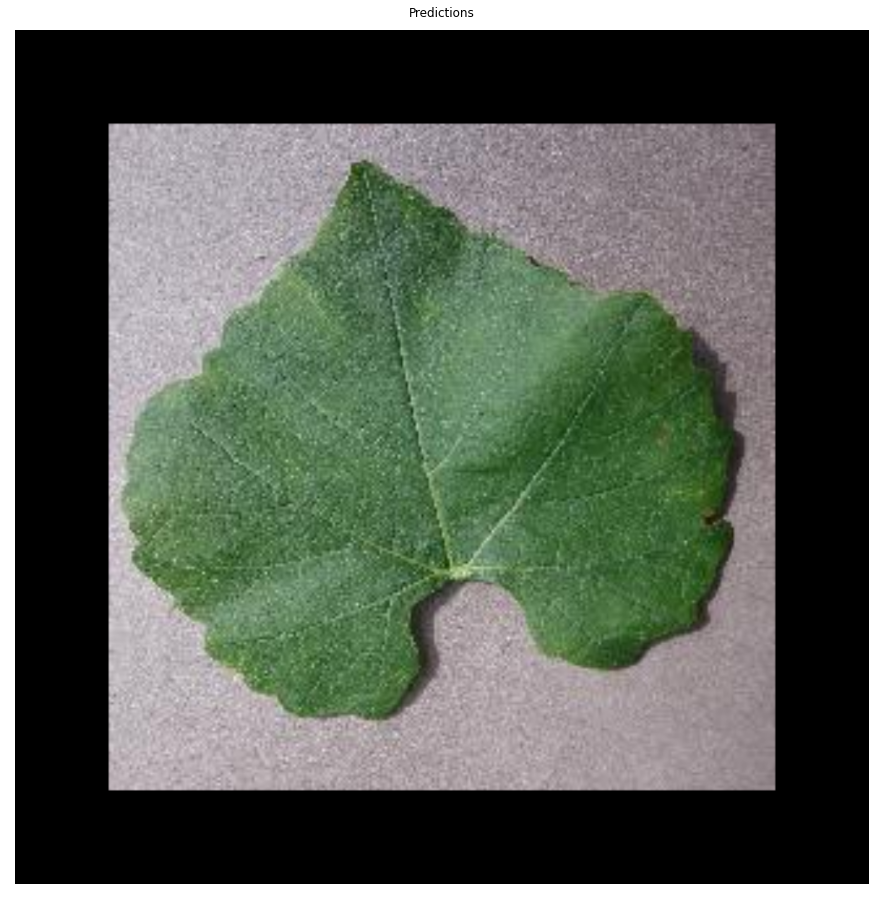

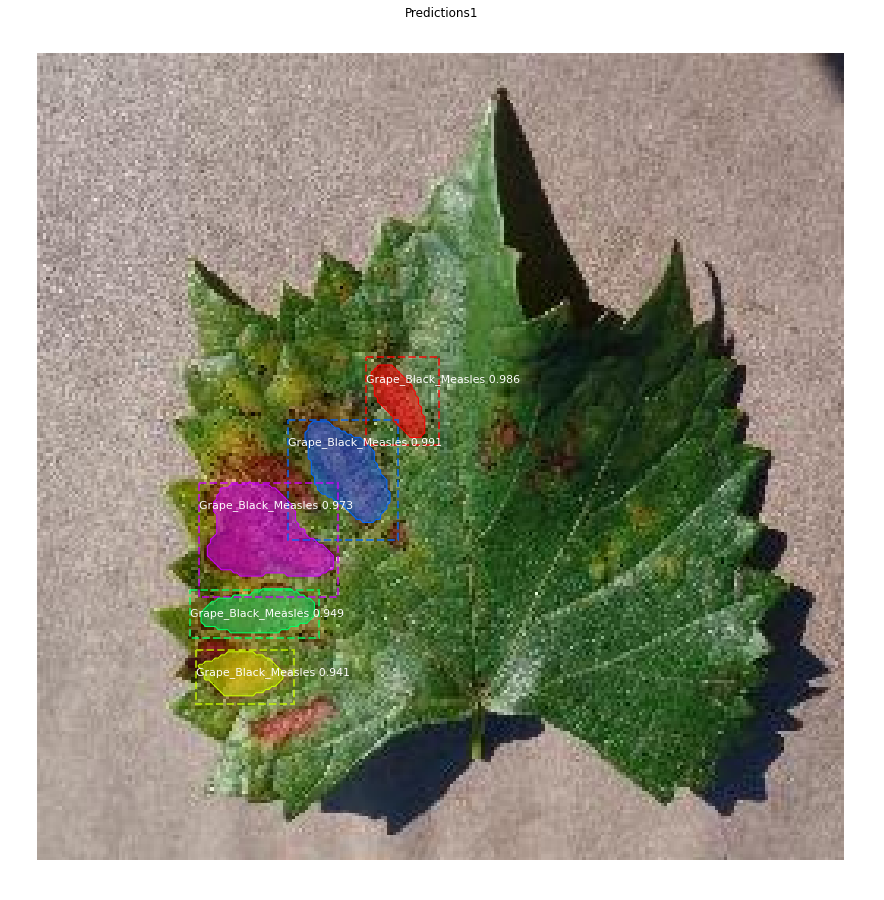

In [11]:
# Display results
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
# This is for predicting images which are not present in dataset
path_to_new_image = 'D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/test_imgs/grape_Black_Measles (6).jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# Prediction on Single Image

1
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


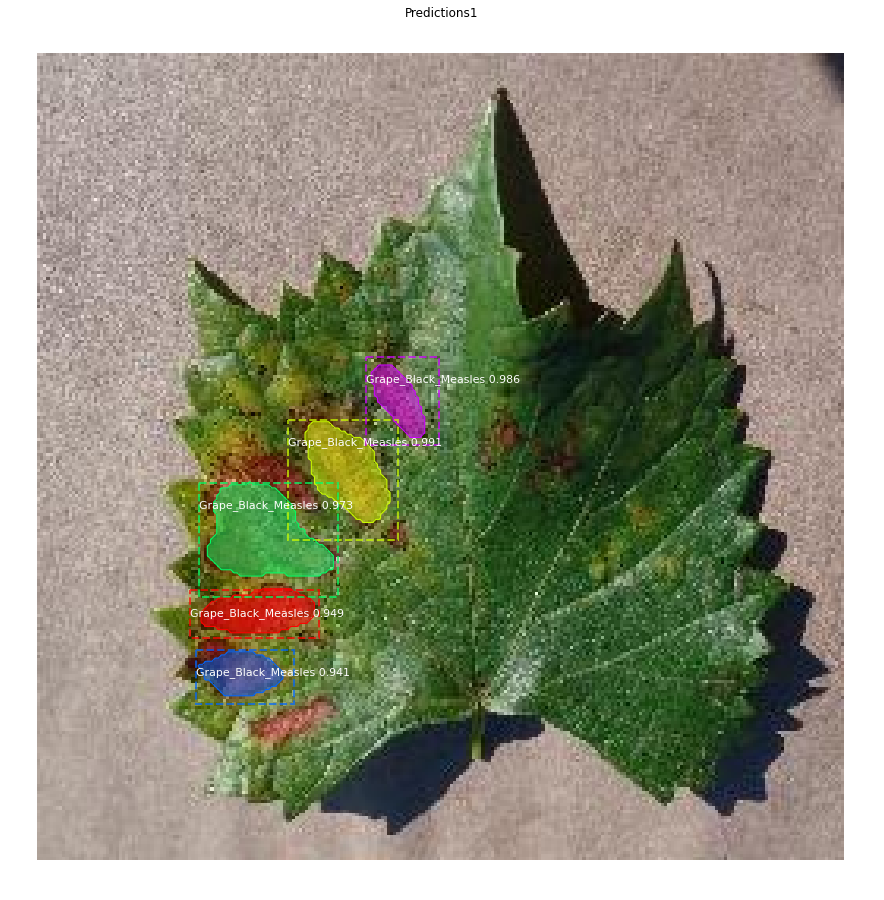

In [ ]:
path_to_new_image = 'D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/test_imgs/grape_Black_Measles (6).jpg'
image1 = mpimg.imread(path_to_new_image)
print(len([image1]))
results1 = model.detect([image1], verbose=1)
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# Displaying the predictions on all the images at once

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


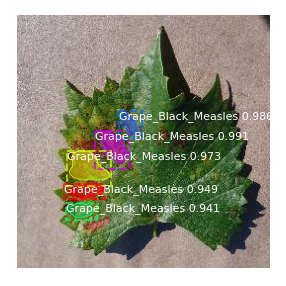

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


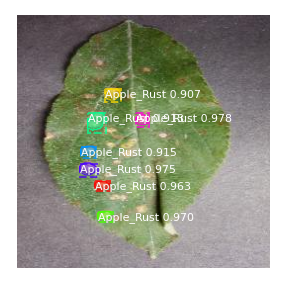

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  134.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


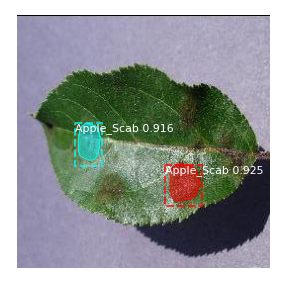

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  229.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  109.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


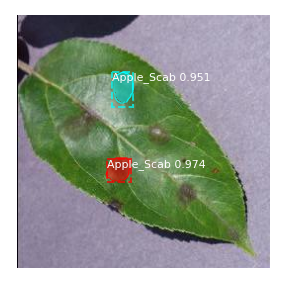

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


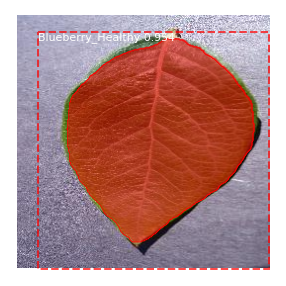

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


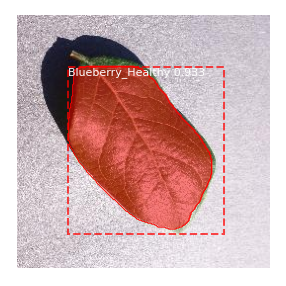

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  132.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


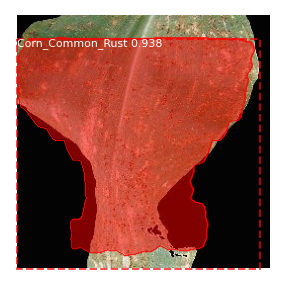

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


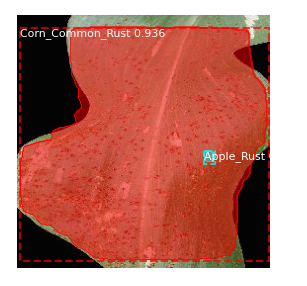

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  224.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   98.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


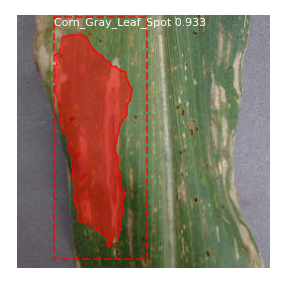

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


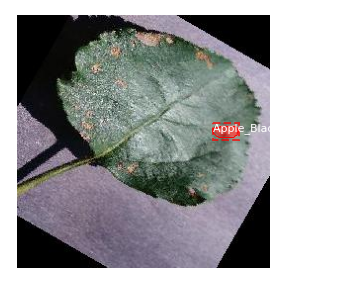

Processing 1 images
image                    shape: (256, 256, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


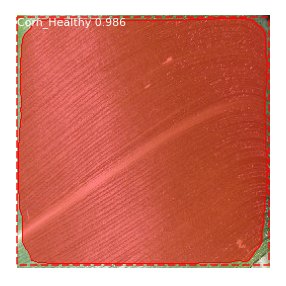

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


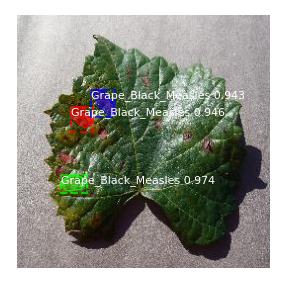

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


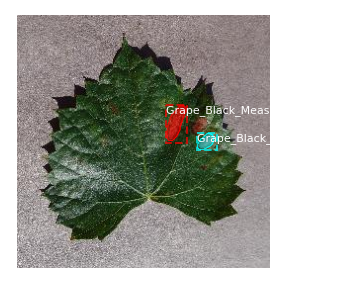

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


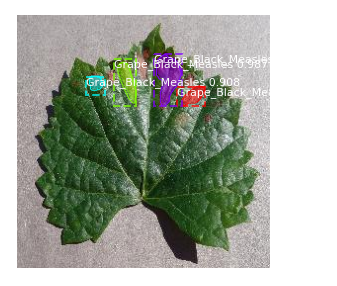

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


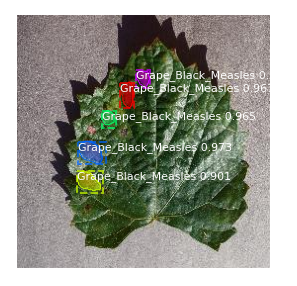

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  237.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  114.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


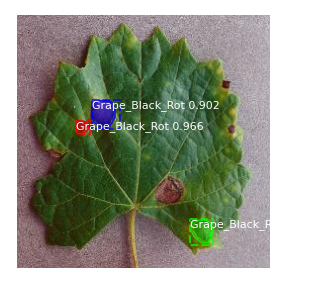

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  235.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  105.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


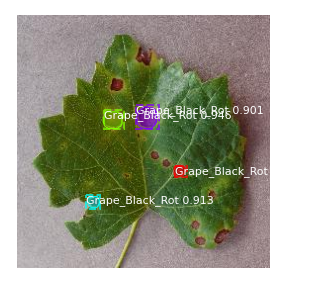

Processing 1 images
image                    shape: (256, 256, 3)         min:   37.00000  max:  233.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  109.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


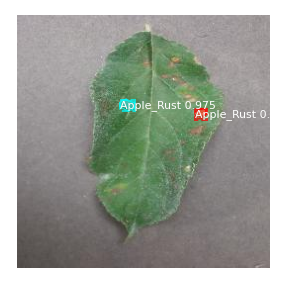

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  224.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   97.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


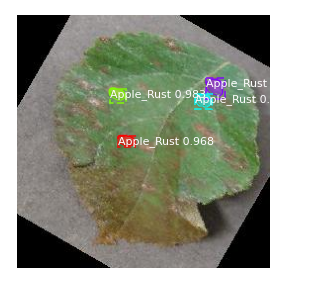

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


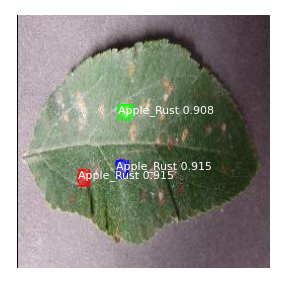

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  113.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


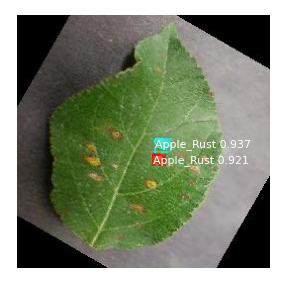

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   97.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


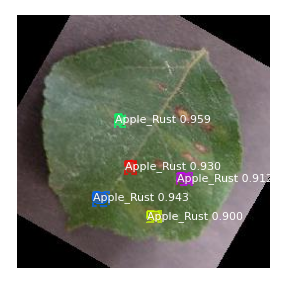

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


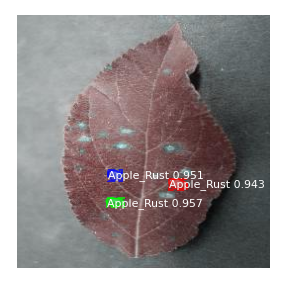

In [ ]:
import skimage
import matplotlib.pyplot as plt
real_test_dir = 'D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/test_imgs'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], figsize=(5,5))

# mean average precision

In [14]:
#import utils

gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []
#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])

    #print("Predicted object : "+dataset.class_names[pred])
    # for j in range(len(dataset.class_names[gt])):
	    # print("Ground truth object : "+j)
import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  3
the actual len of the pred vect is :  3
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt

the actual len of the gt vect is :  54
the actual len of the pred vect is :  54
Average precision of this image :  0.25
The actual mean average precision for the whole images 0.03000000019868215
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  56
the actual len of the pred vect is :  56
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.028125000186264515
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  195.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   91.10000  float64


the actual len of the gt vect is :  69
the actual len of the pred vect is :  69
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.015517241482076973
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  127.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  70
the actual len of the pred vect is :  70
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.015000000099341075
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64


the actual len of the gt vect is :  164
the actual len of the pred vect is :  164
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.06698197474577366
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  168
the actual len of the pred vect is :  168
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.06545965713791517
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float6

the actual len of the gt vect is :  267
the actual len of the pred vect is :  267
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.08411896878366383
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  225.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  121.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  273
the actual len of the pred vect is :  273
Average precision of this image :  0.0833333358168602
The actual mean average precision for the whole images 0.08410542338768445
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  14

the actual len of the gt vect is :  333
the actual len of the pred vect is :  333
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.09335372635756141
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  191.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   75.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  343
the actual len of the pred vect is :  343
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.0920571468248175
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  215.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  100.10000  float64

the actual len of the gt vect is :  369
the actual len of the pred vect is :  369
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1269974263884774
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  370
the actual len of the pred vect is :  370
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.13714861910489046
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64

the actual len of the gt vect is :  391
the actual len of the pred vect is :  391
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.18984627518202607
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  392
the actual len of the pred vect is :  392
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1879478124302058
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64

the actual len of the gt vect is :  429
the actual len of the pred vect is :  429
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.16632549772584584
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  127.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  432
the actual len of the pred vect is :  432
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.16486650213175946
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float6

the actual len of the gt vect is :  445
the actual len of the pred vect is :  445
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.25035260821276045
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  446
the actual len of the pred vect is :  446
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.2562092284610983
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64

the actual len of the gt vect is :  542
the actual len of the pred vect is :  542
Average precision of this image :  0.5
The actual mean average precision for the whole images 0.27817699229649817
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  134.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  552
the actual len of the pred vect is :  552
Average precision of this image :  0.1111111119389534
The actual mean average precision for the whole images 0.2770004720122901
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  140

the actual len of the gt vect is :  661
the actual len of the pred vect is :  661
Average precision of this image :  0.4000000059604645
The actual mean average precision for the whole images 0.2777915706891801
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  673
the actual len of the pred vect is :  673
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2760108554924546
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  197.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   86.

the actual len of the gt vect is :  754
the actual len of the pred vect is :  754
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2631153597617425
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  755
the actual len of the pred vect is :  755
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2615676223513793
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10000  float64


the actual len of the gt vect is :  770
the actual len of the pred vect is :  770
Average precision of this image :  0.3333333432674408
The actual mean average precision for the whole images 0.24480780952460066
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  108.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  772
the actual len of the pred vect is :  772
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2434773322989235
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130

the actual len of the gt vect is :  791
the actual len of the pred vect is :  791
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.23248644235026356
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  124.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  792
the actual len of the pred vect is :  792
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2313122683989996
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64

the actual len of the gt vect is :  821
the actual len of the pred vect is :  821
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.21706080162560154
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  825
the actual len of the pred vect is :  825
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.21603692991982038
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float6

the actual len of the gt vect is :  852
the actual len of the pred vect is :  852
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2079992406355641
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  205.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  101.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  853
the actual len of the pred vect is :  853
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.2115036687743448
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  205.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  101.10000  float64


the actual len of the gt vect is :  881
the actual len of the pred vect is :  881
Average precision of this image :  0.25
The actual mean average precision for the whole images 0.20987841110853922
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  886
the actual len of the pred vect is :  886
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.20900391772892032
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float

the actual len of the gt vect is :  991
the actual len of the pred vect is :  991
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.2009749192070674
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1003
the actual len of the pred vect is :  1003
Average precision of this image :  0.0833333358168602
The actual mean average precision for the whole images 0.20051176336694845
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  1

the actual len of the gt vect is :  1025
the actual len of the pred vect is :  1025
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.19112355017488775
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1026
the actual len of the pred vect is :  1026
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1904104025996083
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  flo

the actual len of the gt vect is :  1046
the actual len of the pred vect is :  1046
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.18160138041528479
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  129.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1047
the actual len of the pred vect is :  1047
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.18095740388898945
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  202.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   96.10000  fl

the actual len of the gt vect is :  1061
the actual len of the pred vect is :  1061
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.19332199287015264
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1062
the actual len of the pred vect is :  1062
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.19604725640775347
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  fl

the actual len of the gt vect is :  1075
the actual len of the pred vect is :  1075
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1942718054909224
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1076
the actual len of the pred vect is :  1076
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.19364512224740332
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  227.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  120.10000  flo

the actual len of the gt vect is :  1109
the actual len of the pred vect is :  1109
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.18585135571732206
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1119
the actual len of the pred vect is :  1119
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.18527774042189823
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  fl

the actual len of the gt vect is :  1186
the actual len of the pred vect is :  1186
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.17961420740859058
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1187
the actual len of the pred vect is :  1187
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1790828044280918
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  flo

the actual len of the gt vect is :  1200
the actual len of the pred vect is :  1200
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.17529911081679495
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1201
the actual len of the pred vect is :  1201
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.17480110197924723
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.20000  fl

the actual len of the gt vect is :  1231
the actual len of the pred vect is :  1231
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1699451723197124
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  216.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   99.20000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1233
the actual len of the pred vect is :  1233
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1694808412478006
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  204.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   89.10000  floa

the actual len of the gt vect is :  1282
the actual len of the pred vect is :  1282
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.16366751423930087
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1286
the actual len of the pred vect is :  1286
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1632368102544606
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  197.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   93.10000  flo

the actual len of the gt vect is :  1326
the actual len of the pred vect is :  1326
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1584732516455344
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1327
the actual len of the pred vect is :  1327
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.15807103527079955
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  flo

the actual len of the gt vect is :  1343
the actual len of the pred vect is :  1343
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.15302208328426295
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1344
the actual len of the pred vect is :  1344
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.15264702915856623
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  230.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  106.30000  fl

the actual len of the gt vect is :  1362
the actual len of the pred vect is :  1362
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.1550593536738599
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1363
the actual len of the pred vect is :  1363
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.15469191444714459
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  140.10000  flo

the actual len of the gt vect is :  1416
the actual len of the pred vect is :  1416
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.15309575764204414
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  234.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  110.30000  float64
image_metas              shape: (1, 41)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1419
the actual len of the pred vect is :  1419
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.15274462058323213
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  207.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   83.30000  fl